In [53]:
import os
import PIL
import cv2
import time
import PIL.Image
import pathlib
import cv2 as cv
import statistics
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from skimage import transform as tf_sk
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from IPython.display import clear_output
from skimage.color import rgb2gray, gray2rgb
from skimage import restoration, filters, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops, hog
from skimage.io import imread, imsave, imshow, imread_collection

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix, accuracy_score
from sklearn.svm import SVC

from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA

In [16]:
# batch_size = 32
img_size = 512

In [57]:
data_dir = pathlib.Path("../BID_fomatter/")

image_count = list(data_dir.glob('*/*.jpg'))
# str(image_count).count("CPF")

In [58]:
images_cnh = list()
images_cpf = list()
images_rg = list()
for img in image_count:
    if str(img).count("CNH"):
        images_cnh.append(str(img))
    elif str(img).count("RG"):
        images_rg.append(str(img))
    elif str(img).count("CPF"):
        images_cpf.append(str(img))
    else:
        print("Algo deu Errado!")


In [59]:
print(len(images_cnh))
print(len(images_cpf))
print(len(images_rg))

images = imread_collection(images_cnh+images_rg+images_cpf)


106
72
108


Text(0.5, 1.0, 'Exemplo de RG')

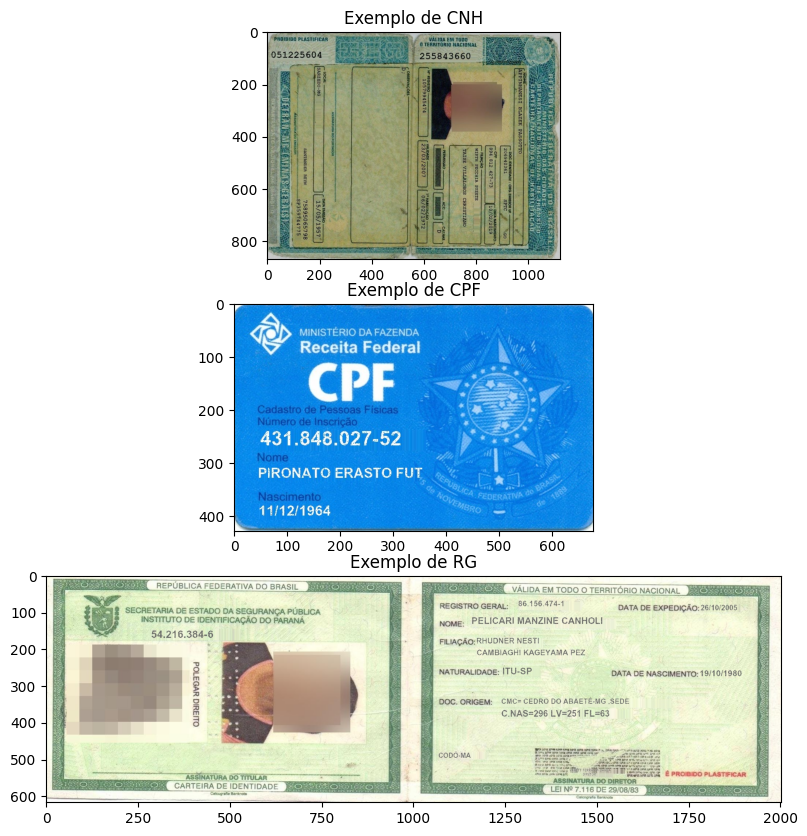

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(images[0])
ax[0].set_title('Exemplo de CNH')
ax[1].imshow(images[110])
ax[1].set_title('Exemplo de CPF')
ax[2].imshow(images[180])
ax[2].set_title('Exemplo de RG')


In [61]:
labels = np.concatenate((np.zeros(len(images_cnh)), np.ones(
    len(images_cpf)), np.ones(len(images_rg)) + 1))
labels


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

## Funcoes

In [31]:
def conv_bordas(imagem, centro, borda='ignore'):

    if borda == 'ignore':
        return imagem

    else:
        print("Borda desconhecida!")
        return None


In [32]:
def convolucao(imagem, filtro, borda='ignore'):
    imagem_h, imagem_w = imagem.shape[:2]
    kernel_h, kernel_w = filtro.shape[:2]

    if borda == 'ignore':
        centro = ((kernel_h-1)//2)*(-1)
    else:
        centro = ((kernel_h-1)//2)

    imagem = np.array(conv_bordas(imagem, centro, borda))

    #Verifica camadas
    camadas = len(imagem.shape)
    if(camadas == 2):
        # Inicializa imagem de saída com zeros
        imagem_processada = np.array(imagem)
        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                    2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                # Aplica o filtro de convolução
                #print(sub_imagem.shape)
                imagem_processada[i, j] = np.sum(sub_imagem * filtro)

        if borda != 'ignore':
            # Remove as bordas adicionadas
            imagem_processada = imagem_processada[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]

        imagem_processada = cv.normalize(
            imagem_processada,  None, 0, 255, cv.NORM_MINMAX)

    else:

        imagemr = imagem[:, :, 0]
        imagemg = imagem[:, :, 1]
        imagemb = imagem[:, :, 2]
        # Inicializa cada camada da imagem de saída com zeros
        imagem_processadar = np.array(imagemr)
        imagem_processadag = np.array(imagemg)
        imagem_processadab = np.array(imagemb)

        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                      2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                      2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                      2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]

                # Aplica o filtro de convolução
                imagem_processadar[i, j] = np.sum(sub_imagemr * filtro)
                imagem_processadag[i, j] = np.sum(sub_imagemg * filtro)
                imagem_processadab[i, j] = np.sum(sub_imagemb * filtro)

        if borda != 'ignore':
            # Remove as bordas adicionadas

            imagem_processadar = imagem_processadar[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadag = imagem_processadag[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadab = imagem_processadab[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
        imagem_processadar = cv.normalize(
            imagem_processadar,  None, 0, 255, cv.NORM_MINMAX)
        imagem_processadag = cv.normalize(
            imagem_processadag,  None, 0, 255, cv.NORM_MINMAX)
        imagem_processadab = cv.normalize(
            imagem_processadab,  None, 0, 255, cv.NORM_MINMAX)

        imagem_processada = np.dstack(
            (imagem_processadar, imagem_processadag, imagem_processadab))
    return imagem_processada


In [33]:
def convolucao_q2(imagem, filtro, borda, tipo):
    imagem_h, imagem_w = imagem.shape[:2]
    kernel_h = filtro[0]
    kernel_w = filtro[1]

    if borda == 'ignore':
      centro = ((kernel_h-1)//2)*(-1)
    else:
      centro = ((kernel_h-1)//2)

    imagem = conv_bordas(imagem, centro, borda)

    #Verifica camadas
    camadas = len(imagem.shape)
    if(camadas == 2):
        # Inicializa imagem de saída com zeros
        imagem_processada = np.zeros_like(imagem)
        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                if tipo == 'mediana':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = np.median(sub_imagem)
                if tipo == 'moda':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = statistics.mode(
                        np.ravel(sub_imagem))
                if tipo == 'maximo':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = sub_imagem.max()
                if tipo == 'minimo':
                    # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                    sub_imagem = imagem[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                        2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processada[i, j] = sub_imagem.min()

    else:

        imagemr = imagem[:, :, 0]
        imagemg = imagem[:, :, 1]
        imagemb = imagem[:, :, 2]
        # Inicializa cada camada da imagem de saída com zeros
        imagem_processadar = np.zeros_like(imagemr)
        imagem_processadag = np.zeros_like(imagemg)
        imagem_processadab = np.zeros_like(imagemb)

        # Loop através de cada pixel da imagem
        for i in range((kernel_h-1)//2, imagem_h+centro):
            for j in range((kernel_w-1)//2, imagem_w+centro):
                # Obtém sub-imagem de tamanho do kernel centrada no pixel atual
                if tipo == 'mediana':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = np.median(sub_imagemr)
                    imagem_processadag[i, j] = np.median(sub_imagemg)
                    imagem_processadab[i, j] = np.median(sub_imagemb)
                if tipo == 'moda':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = statistics.mode(
                        np.ravel(sub_imagemr))
                    imagem_processadag[i, j] = statistics.mode(
                        np.ravel(sub_imagemg))
                    imagem_processadab[i, j] = statistics.mode(
                        np.ravel(sub_imagemb))
                if tipo == 'maximo':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = sub_imagemr.max()
                    imagem_processadag[i, j] = sub_imagemg.max()
                    imagem_processadab[i, j] = sub_imagemb.max()
                if tipo == 'minimo':
                    sub_imagemr = imagemr[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemg = imagemg[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    sub_imagemb = imagemb[i-(kernel_h-1)//2:i+(kernel_h-1) //
                                          2+1, j-(kernel_w-1)//2:j+(kernel_w-1)//2+1]
                    # Aplica o filtro de convolução
                    imagem_processadar[i, j] = sub_imagemr.min()
                    imagem_processadag[i, j] = sub_imagemg.min()
                    imagem_processadab[i, j] = sub_imagemb.min()
        if borda != 'ignore':
            # Remove as bordas adicionadas
            imagem_processadar = imagem_processadar[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadag = imagem_processadag[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]
            imagem_processadab = imagem_processadab[(
                kernel_h-1)//2:(kernel_h-1)//2+imagem_h, (kernel_w-1)//2:(kernel_w-1)//2+imagem_w]

        imagem_processada = np.dstack(
            (imagem_processadar, imagem_processadag, imagem_processadab))
    return imagem_processada


In [17]:
def seg_otsu(path, path_img):

    img = imread(path_img)

    if len(img.shape) > 2:
        img = rgb2gray(img)

    threshold = filters.threshold_otsu(img)
    binarized_img = (img > threshold)*1

    binarized_img_norm = cv2.normalize(src=binarized_img, dst=None, alpha=0,
                                       beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    name_img = str(path_img).split('/')[-1]

    os.makedirs("../seg_otsu/{}/".format(path), exist_ok=True)
    imsave('../seg_otsu/{}/{}'.format(path,
           name_img), binarized_img_norm)


In [18]:
def seg_niblack(path, path_img):

    img = imread(path_img)

    if len(img.shape) > 2:
        img = rgb2gray(img)

    threshold = filters.threshold_niblack(img)
    binarized_img = (img > threshold)*1

    binarized_img_norm = cv2.normalize(src=binarized_img, dst=None, alpha=0,
                                       beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    name_img = str(path_img).split('/')[-1]

    os.makedirs("../seg_niblack/{}/".format(path), exist_ok=True)
    imsave('../seg_niblack/{}/{}'.format(path,
           name_img), binarized_img_norm)


## Etapa 01 - Filtros

In [54]:
count = 0
for img in images:
    img_filter_minimo=convolucao_q2(rgb2gray(img),[13,13],'ignore', "minimo")
    
    img_filter_minimo = cv2.normalize(src=img_filter_minimo, dst=None, alpha=0,
                                      beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    imsave('../filtro_minimo/{}.png'.format(count), img_filter_minimo, check_contrast=False)
    
    count += 1

## Etapa 02 - Segmentacao

In [22]:
data_dir_fil = pathlib.Path("../filtro_minimo/")

filtered_image = list(data_dir_fil.glob('*'))


In [20]:
for img in filtered_image:
    seg_otsu("imagem_filtrada", img)
    seg_niblack("imagem_filtrada", img)


In [23]:
data_dir_fil = pathlib.Path("../seg_otsu/imagem_filtrada/")

filtered_image = list(data_dir_fil.glob('*'))

listAux = list()
for img in filtered_image:
    listAux.append(str(img))

images_seg = imread_collection(listAux)


In [24]:
images_segmented = list()
for in_img in range(len(images)):
    images_segmented.append(cv2.bitwise_and(images[in_img], images[in_img], mask=images_seg[in_img]))

## Etapa 03 - Descricao

#### - Using GLCM

In [25]:
# data_dir_fil = pathlib.Path("../seg_otsu/imagem_filtrada/")

# filtered_image = list(data_dir_fil.glob('*'))

# listAux = list()
# for img in filtered_image:
#     listAux.append(str(img))

# images = imread_collection(listAux)


In [26]:
d = 2

##### Imagens segmentadas

In [27]:
features = np.zeros((len(labels), 18))  # 6 features x 3 color channels
start = time.time()

for id_im, imagem in enumerate(images_segmented):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(
        id_im+1, len(images_segmented)))
    for id_ch in range(3):
        matrix0 = graycomatrix(imagem[:, :, id_ch], [d], [0], normed=True)
        matrix1 = graycomatrix(imagem[:, :, id_ch], [d], [np.pi/4], normed=True)
        matrix2 = graycomatrix(imagem[:, :, id_ch], [d], [np.pi/2], normed=True)
        matrix3 = graycomatrix(imagem[:, :, id_ch], [d], [3*np.pi/4], normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4
        props = np.zeros((6))
        props[0] = graycoprops(matrix, 'contrast')
        props[1] = graycoprops(matrix, 'dissimilarity')
        props[2] = graycoprops(matrix, 'homogeneity')
        props[3] = graycoprops(matrix, 'energy')
        props[4] = graycoprops(matrix, 'correlation')
        props[5] = graycoprops(matrix, 'ASM')
        features[id_im, id_ch*6:(id_ch+1)*6] = props

end = time.time()
print(end - start)


Extraindo atributos: 286 imagens processadas de 286.
8.83236312866211


##### Imagens Normais

In [28]:
features_2 = np.zeros((len(labels), 18))  # 6 features_2 x 3 color channels
start = time.time()

for id_im, imagem in enumerate(images):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(
        id_im+1, len(images)))
    for id_ch in range(3):
        matrix0 = graycomatrix(imagem[:, :, id_ch], [d], [0], normed=True)
        matrix1 = graycomatrix(imagem[:, :, id_ch], [
                               d], [np.pi/4], normed=True)
        matrix2 = graycomatrix(imagem[:, :, id_ch], [
                               d], [np.pi/2], normed=True)
        matrix3 = graycomatrix(imagem[:, :, id_ch], [d], [
                               3*np.pi/4], normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4
        props = np.zeros((6))
        props[0] = graycoprops(matrix, 'contrast')
        props[1] = graycoprops(matrix, 'dissimilarity')
        props[2] = graycoprops(matrix, 'homogeneity')
        props[3] = graycoprops(matrix, 'energy')
        props[4] = graycoprops(matrix, 'correlation')
        props[5] = graycoprops(matrix, 'ASM')
        features_2[id_im, id_ch*6:(id_ch+1)*6] = props

end = time.time()
print(end - start)


Extraindo atributos: 286 imagens processadas de 286.
10.82266902923584


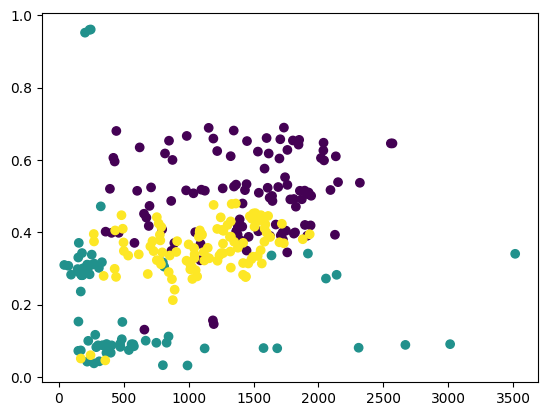

In [29]:
plt.scatter(features[:,0],features[:,3],c=labels)

In [30]:
pca = PCA()
pca.fit(features)
transform = pca.transform(features)
print(np.sum(pca.explained_variance_ratio_[0:3]))


0.9999644257683233


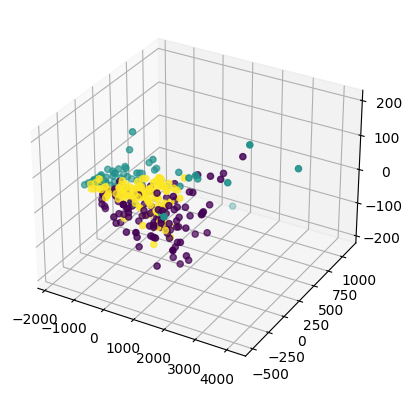

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transform[:,0],transform[:,1],transform[:,2],c=labels)

#### - Using HOG

In [34]:
hog_features = []
for image in images_segmented:
    #Deixar todas as imagens do mesmo tamanho
    resized_image = tf_sk.resize(
        image, (img_size, img_size), anti_aliasing=True)
    fd = hog(resized_image, orientations=8, pixels_per_cell=(16, 16),
             cells_per_block=(1, 1), visualize=False, block_norm='L2-Hys', channel_axis=2)
    hog_features.append(fd)
    
hog_features = np.array(hog_features)


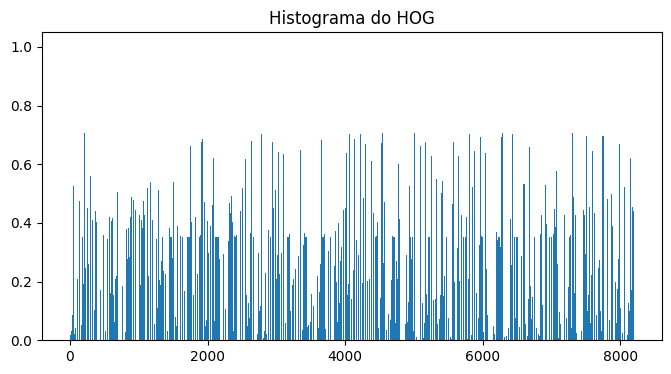

In [35]:
# Plot de cada imagem


fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(range(len(hog_features[0])), hog_features[0])
ax.set_title('Histograma do HOG')

plt.show()


## Etapa 04 - Classificacao

### Using RandomForest

#### - Using GLCM

In [ ]:
train = 0.9
test = 1-train

In [ ]:
#Imagens segmentadas

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test)

#Imagens normais
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    features_2, labels, test_size=test)


In [ ]:
#Imagens Segmentadas

c_rf = RandomForestClassifier()
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy Random Forest: {}'.format(acc_rf))


Accuracy Random Forest: 0.896551724137931


In [ ]:
#Imagens Normais

c_rf = RandomForestClassifier()
c_rf.fit(X_train_2, y_train_2)
pred = c_rf.predict(X_test_2)
acc_rf = accuracy_score(y_test_2, pred)
print('Accuracy Random Forest: {}'.format(acc_rf))


Accuracy Random Forest: 0.7586206896551724


In [ ]:
#Imagens Segmentadas

acc_rf = []
c_rf = RandomForestClassifier()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test)
    c_rf.fit(X_train, y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Mean accuracy Random Forest: 0.8831034482758621+-0.05428050630789674


In [ ]:
#Imagens Normais

acc_rf = []
c_rf = RandomForestClassifier()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        features_2, labels, test_size=test)
    c_rf.fit(X_train, y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Mean accuracy Random Forest: 0.8013793103448276+-0.06829327538304623


In [ ]:

def rf_parameter_estimation(xEst, yEst):

    clf = RandomForestClassifier(n_estimators=20)
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10, 1000, 50),
                       "max_depth": range(1, 100),
                       "max_features": sp_randint(1, xEst.shape[1]),
                       "min_samples_split": sp_randint(2, xEst.shape[1]),
                       "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                       "bootstrap": [True, False],
                       "criterion": ["gini", "entropy"]}

    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search, scoring=make_scorer(accuracy_score))

    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))


In [ ]:
start = time.time()

parameters = rf_parameter_estimation(X_train, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)

end = time.time()
print(end - start)


Model with rank: 1
Mean validation score: 0.879 (std: 0.041)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 86, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 260}
Model with rank: 2
Mean validation score: 0.879 (std: 0.022)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 51, 'max_features': 5, 'min_samples_leaf': 16, 'min_samples_split': 3, 'n_estimators': 660}
Model with rank: 3
Mean validation score: 0.872 (std: 0.023)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 74, 'max_features': 5, 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 660}
100.25200247764587


In [ ]:
print('Random Forest Accuracy: ',acc_rf)

Random Forest Accuracy:  0.7931034482758621


##### Classification using PCA

In [ ]:
components = [6,8,10,12]

In [ ]:
def pca(X_train, X_test, y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train, y_train)
    transform = pca.transform(X_test)
    return transform


In [ ]:
results_rf = np.zeros(5)

start = time.time()
for id_comp, comp in enumerate(components):

    print('-------------', 'n comp. = ', comp, '-------------')

    X_train_pca = pca(X_train, X_train, y_train, comp)

    X_test_pca = pca(X_train, X_test, y_train, comp)

    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca, y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc


end = time.time()
print(end - start)


------------- n comp. =  6 -------------
Model with rank: 1
Mean validation score: 0.918 (std: 0.038)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 55, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 160}
Model with rank: 2
Mean validation score: 0.910 (std: 0.037)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 810}
Model with rank: 3
Mean validation score: 0.903 (std: 0.025)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 710}
------------- n comp. =  8 -------------
Model with rank: 1
Mean validation score: 0.891 (std: 0.042)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 97, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 860}
Model with rank: 2
Mean validation score

Text(0.5, 1.0, 'Helmets')

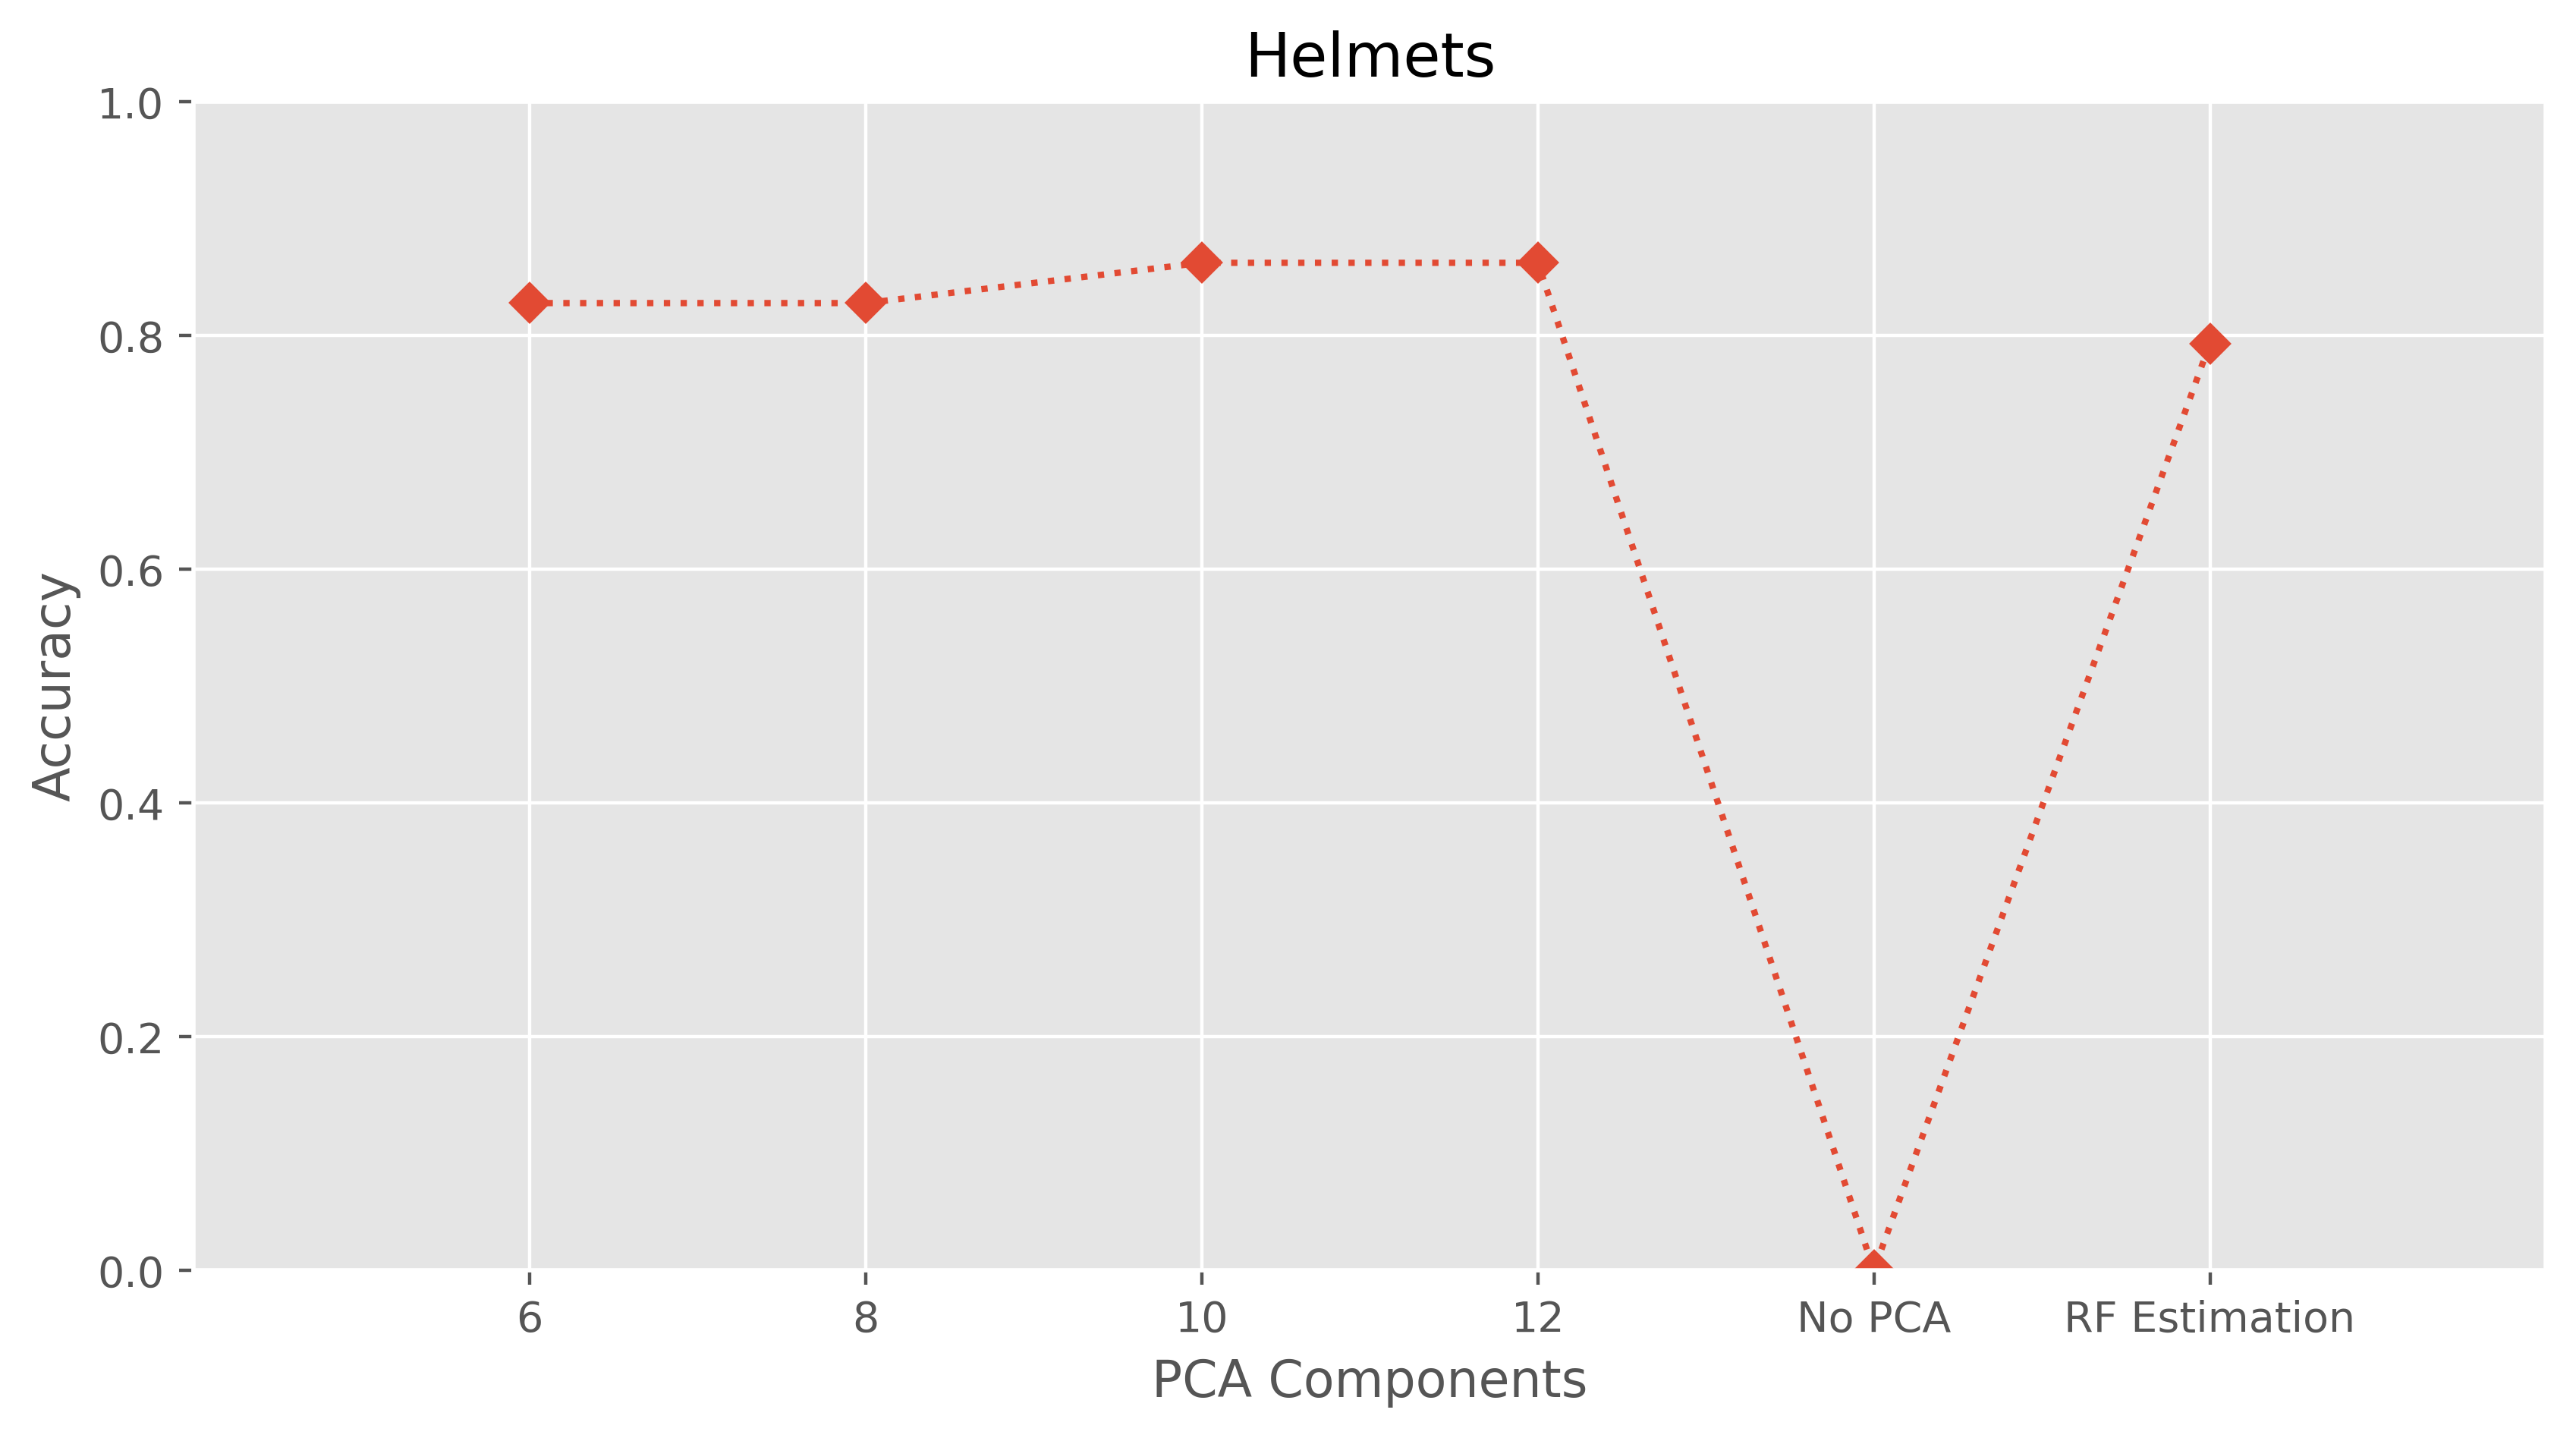

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5), dpi=400)
ax = plt.subplot(111)
ax.plot(range(1, 7), np.concatenate(
    (results_rf, [acc_rf]), axis=0), marker='D', linestyle=':', label='Random Forest')
ax.set_xlim([0, 7])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1, 7))
ax.set_xticklabels(['6', '8', '10', '12', 'No PCA', "RF Estimation"])
ax.set_ylim([0, 1])
ax.set_title('Helmets')


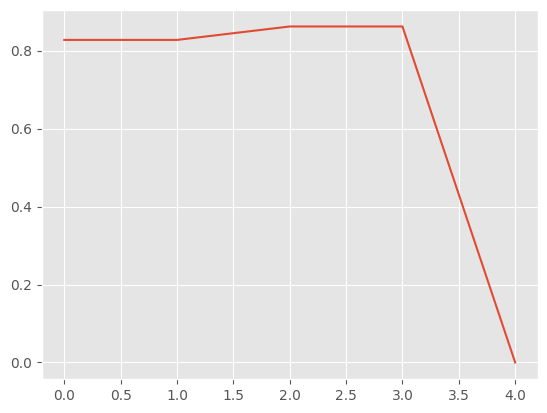

In [ ]:
plt.plot(results_rf)


#### - Using HOG

In [76]:
train = 0.9
test = 1-train


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels, test_size=test)


In [61]:
#Imagens Segmentadas

c_rf = RandomForestClassifier()
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy Random Forest: {}'.format(acc_rf))


Accuracy Random Forest: 0.896551724137931


In [75]:
#Imagens Segmentadas

acc_rf = []
c_rf = RandomForestClassifier()
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        hog_features, labels, test_size=test)
    c_rf.fit(X_train, y_train)
    pred = c_rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Mean accuracy Random Forest: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Mean accuracy Random Forest: 0.9579310344827586+-0.03949141600612527


In [79]:

def rf_parameter_estimation(xEst, yEst):

    clf = RandomForestClassifier(n_estimators=20)
    # specify parameters and distributions to sample from
    hyperparameters = {"n_estimators": range(10, 1000, 50),
                       "max_depth": range(1, 100),
                       "max_features": sp_randint(1, xEst.shape[1]),
                       "min_samples_split": sp_randint(2, xEst.shape[1]),
                       "min_samples_leaf": sp_randint(1, xEst.shape[1]),
                       "bootstrap": [True, False],
                       "criterion": ["gini", "entropy"]}

    # run randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(clf, param_distributions=hyperparameters,
                                       n_iter=n_iter_search, scoring=make_scorer(accuracy_score))

    random_search.fit(xEst, yEst)
    report(random_search.cv_results_)
    return random_search.best_params_


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))


In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test)


In [96]:
start = time.time()

parameters = rf_parameter_estimation(X_train, y_train)
c_rf = RandomForestClassifier(**parameters)
c_rf.fit(X_train, y_train)
pred = c_rf.predict(X_test)
acc_rf = accuracy_score(y_test, pred)

end = time.time()
print(end - start)


Model with rank: 1
Mean validation score: 0.876 (std: 0.044)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 21, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 14, 'n_estimators': 160}
Model with rank: 2
Mean validation score: 0.876 (std: 0.041)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 82, 'max_features': 6, 'min_samples_leaf': 9, 'min_samples_split': 14, 'n_estimators': 960}
Model with rank: 2
Mean validation score: 0.876 (std: 0.041)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 53, 'max_features': 9, 'min_samples_leaf': 12, 'min_samples_split': 12, 'n_estimators': 660}
95.07469749450684


In [97]:
print('Random Forest Accuracy: ',acc_rf)

Random Forest Accuracy:  0.8275862068965517


##### Classification using PCA

In [98]:
components = [6,8,10,12]

In [99]:
def pca(X_train, X_test, y_train, n_comp):
    """
    PCA transformation for using a 'training' set and a 'testing' set
    """
    pca = PCA(n_components=n_comp)
    pca.fit(X_train, y_train)
    transform = pca.transform(X_test)
    return transform


In [100]:
results_rf = np.zeros(5)

start = time.time()
for id_comp, comp in enumerate(components):

    print('-------------', 'n comp. = ', comp, '-------------')

    X_train_pca = pca(X_train, X_train, y_train, comp)

    X_test_pca = pca(X_train, X_test, y_train, comp)

    #RF
    parameters = rf_parameter_estimation(X_train_pca, y_train)
    c_rf = RandomForestClassifier(**parameters)
    c_rf.fit(X_train_pca, y_train)
    pred = c_rf.predict(X_test_pca)
    acc = accuracy_score(y_test, pred)
    results_rf[id_comp] = acc


end = time.time()
print(end - start)


------------- n comp. =  6 -------------
Model with rank: 1
Mean validation score: 0.883 (std: 0.037)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 75, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 910}
Model with rank: 2
Mean validation score: 0.880 (std: 0.033)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 46, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 310}
Model with rank: 3
Mean validation score: 0.876 (std: 0.036)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 81, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 760}
------------- n comp. =  8 -------------
Model with rank: 1
Mean validation score: 0.879 (std: 0.025)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 960}
Model with rank: 2
Mean validation score:

Text(0.5, 1.0, 'Helmets')

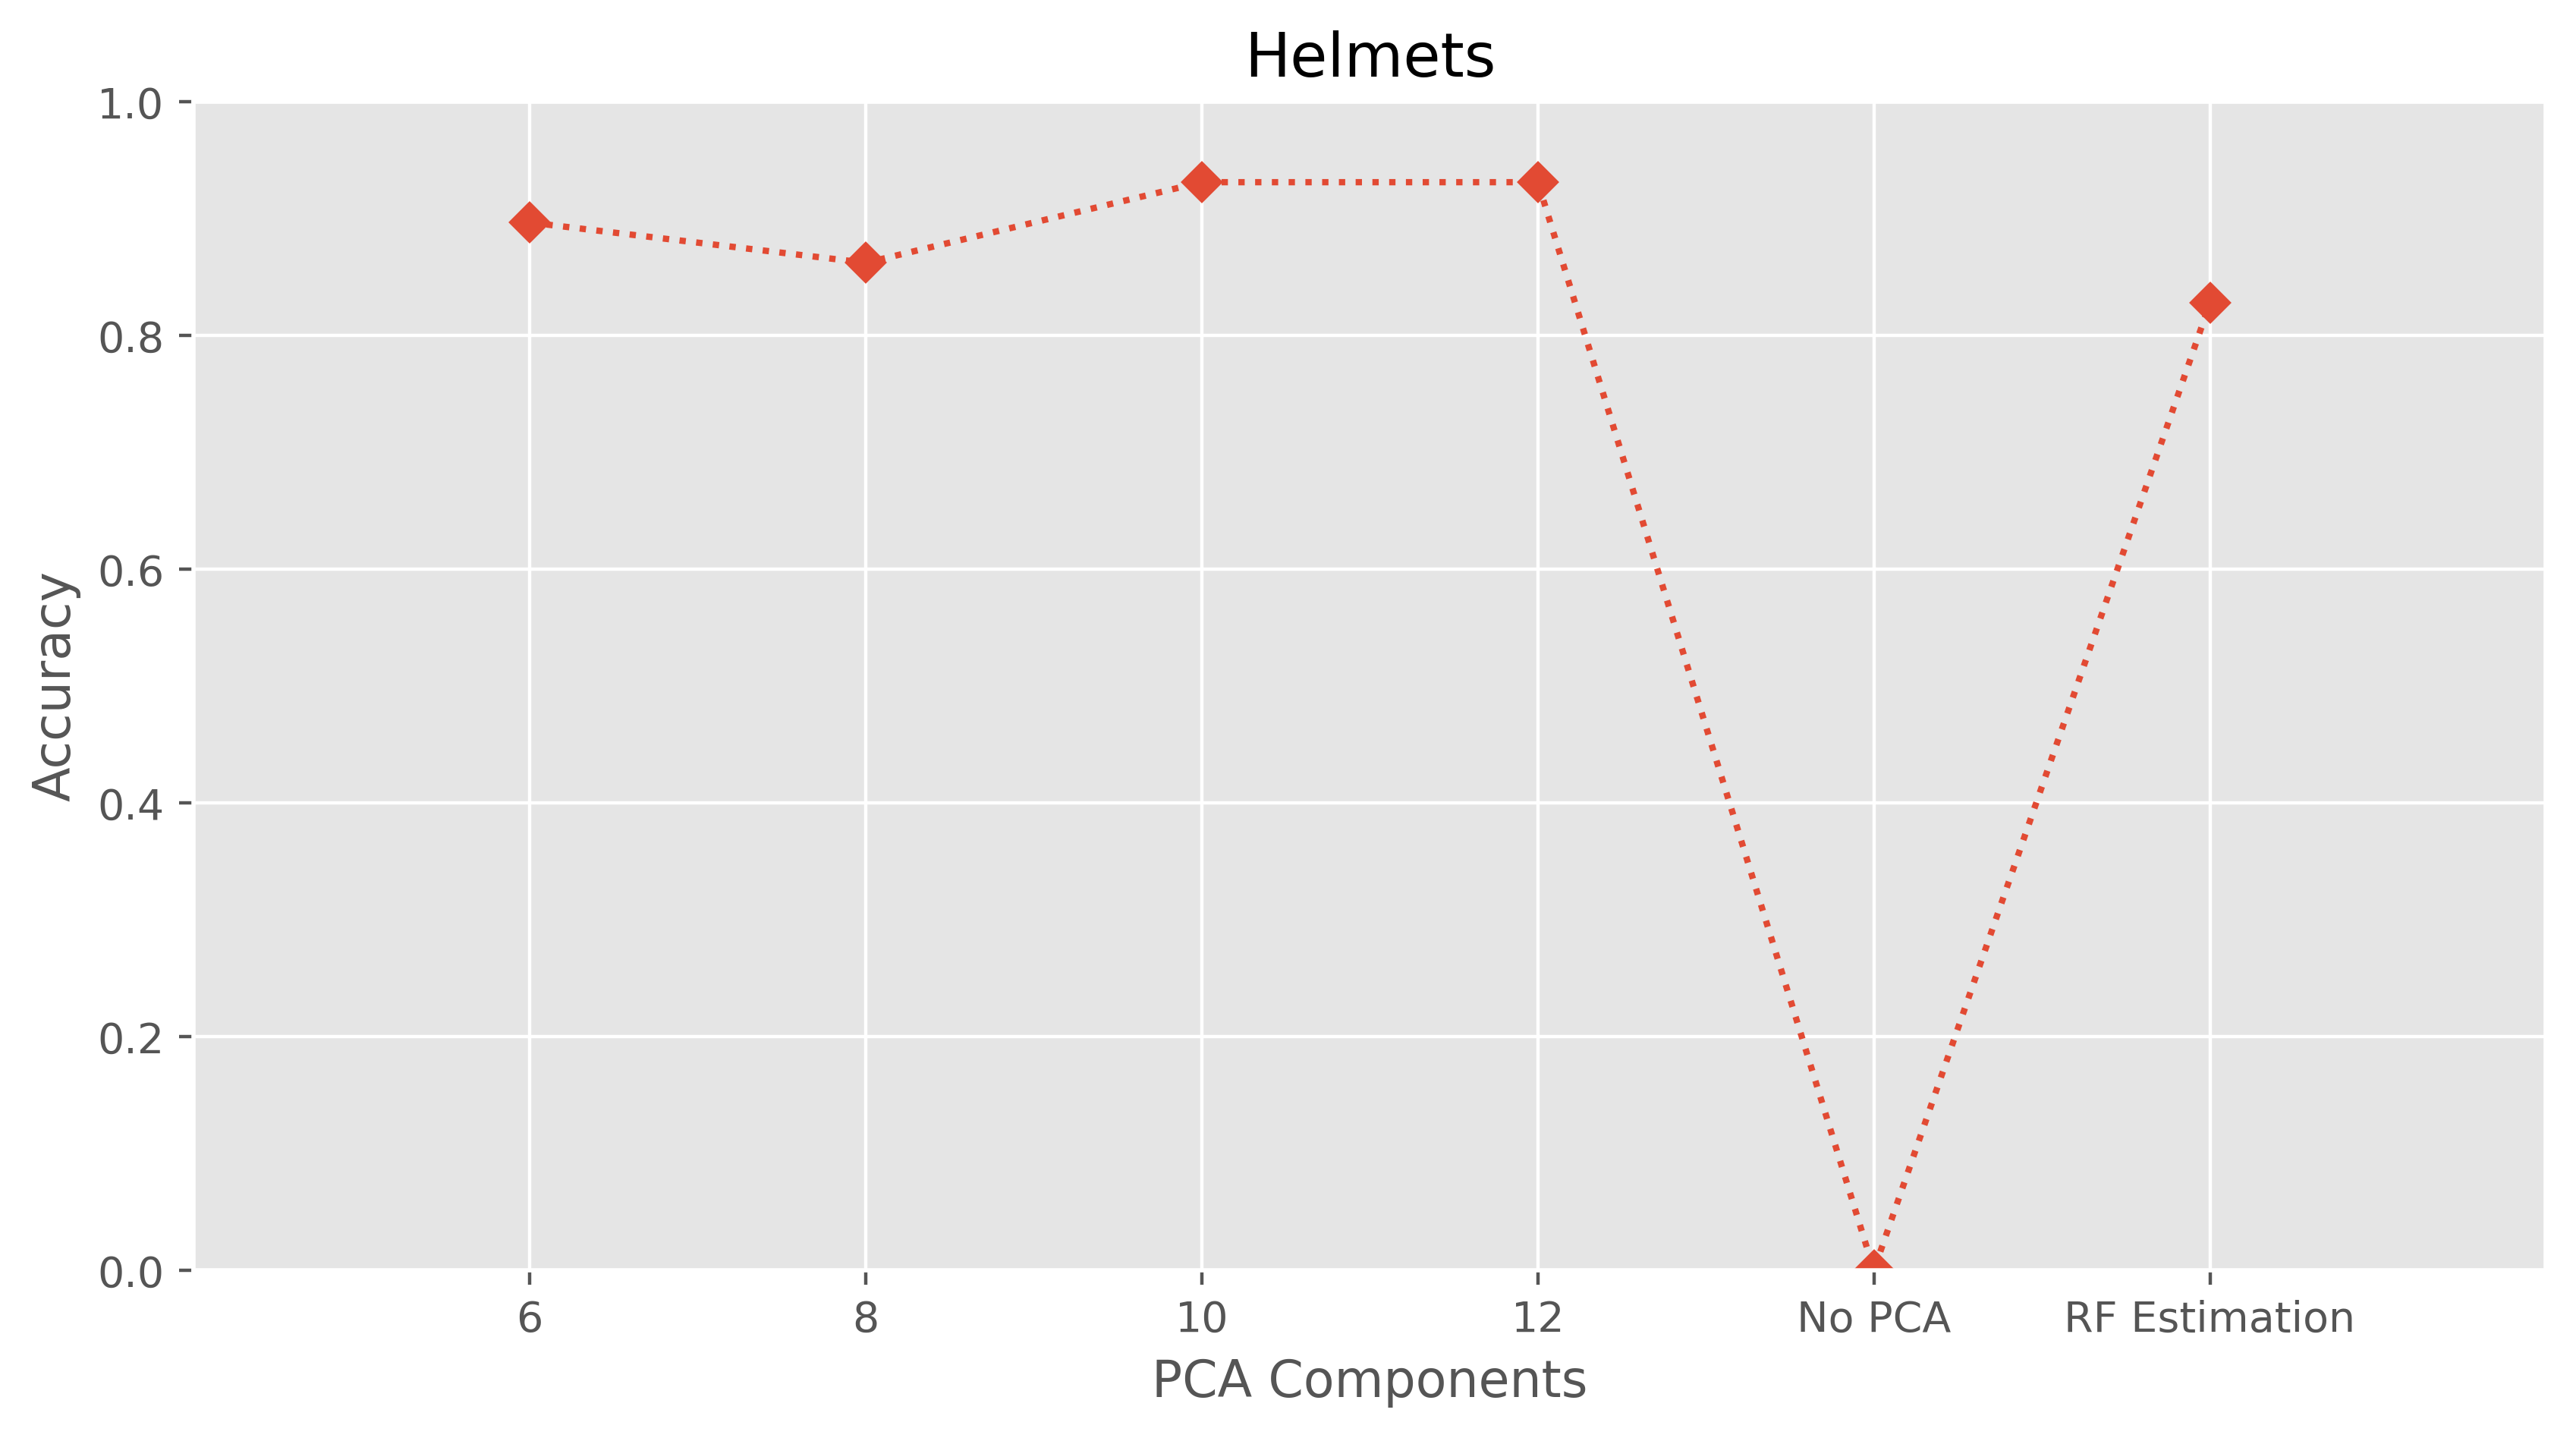

In [101]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5), dpi=400)
ax = plt.subplot(111)
ax.plot(range(1, 7), np.concatenate(
    (results_rf, [acc_rf]), axis=0), marker='D', linestyle=':', label='Random Forest')
ax.set_xlim([0, 7])
ax.set_xlabel('PCA Components')
ax.set_ylabel('Accuracy')
ax.set_xticks(range(1, 7))
ax.set_xticklabels(['6', '8', '10', '12', 'No PCA', "RF Estimation"])
ax.set_ylim([0, 1])
ax.set_title('Helmets')


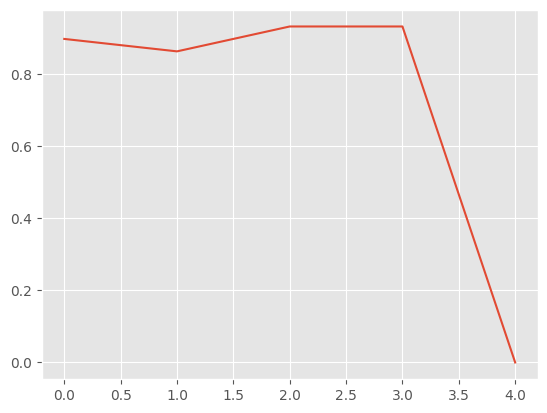

In [102]:
plt.plot(results_rf)


### Using SVC

#### - Using GLCM

In [36]:
train = 0.9
test = 1-train

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
                        features, labels, test_size=test)


In [40]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy SVC: {}'.format(acc_rf))


Accuracy SVC: 0.896551724137931


In [41]:
#Imagens normais
X_train, X_test, y_train, y_test = train_test_split(
    features_2, labels, test_size=test)

svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy SVC: {}'.format(acc_rf))


Accuracy SVC: 0.7931034482758621


In [46]:
epochs = 10
acc_rf = []
c_rf = SVC(kernel='linear')
for i in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=test)
    svc = SVC(kernel='linear', C=1)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Imagens Filtradas - Mean accuracy SVC: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Imagens Filtradas - Mean accuracy SVC: 0.8517241379310345+-0.043753715656722474


In [44]:
epochs = 5
acc_rf = []
c_rf = SVC(kernel='linear')
for i in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(
        features_2, labels, test_size=test)
    svc = SVC(kernel='linear', C=1)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Imagens Normais - Mean accuracy SVC: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Imagens Normais - Mean accuracy SVC: 0.8+-0.033786065417699


#### - Using HOG

In [47]:
train = 0.9
test = 1-train


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, labels, test_size=test)


In [49]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
acc_rf = accuracy_score(y_test, pred)
print('Accuracy SVC: {}'.format(acc_rf))

Accuracy SVC: 1.0


In [50]:
epochs = 10
acc_rf = []
c_rf = SVC(kernel='linear')
for i in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(
        hog_features, labels, test_size=test)
    svc = SVC(kernel='linear', C=1)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    acc_rf.append(accuracy_score(y_test, pred))
print("Imagens Filtradas - Mean accuracy SVC: {}+-{}".format(np.mean(acc_rf), np.std(acc_rf)))


Imagens Filtradas - Mean accuracy SVC: 0.9862068965517242+-0.016893032708849485


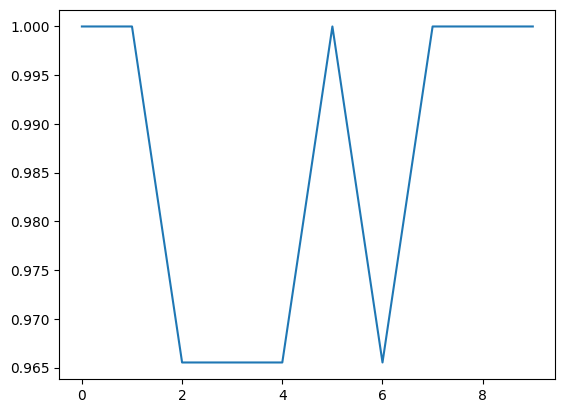

In [51]:
plt.plot(acc_rf)


## Etapa 05 - K-Fold

In [81]:
# Define o número de folds
k = 5

# Cria o objeto KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [82]:
accuracies = []

# Iterando sobre os folds
for train_idx, test_idx in kf.split(hog_features):
    X_train, X_test = hog_features[train_idx], hog_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    model = SVC(kernel='linear')
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy}")
    
mean_accuracy = sum(accuracies) / len(accuracies)
std_accuracy = np.std(accuracies)

print("-=-=-=-=-=-")
print(f"Acurácia média: {mean_accuracy:.3f}")
print(f"Desvio padrão: {std_accuracy:.3f}")
print("-=-=-=-=-=-")


Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.9824561403508771
Accuracy: 0.9824561403508771
Accuracy: 0.9824561403508771
-=-=-=-=-=-
Acurácia média: 0.989
Desvio padrão: 0.009
-=-=-=-=-=-
